In [49]:
import saha_mult
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as sc
import importlib 
importlib.reload(saha_mult)

<module 'saha_mult' from '/home/nalamwar/Research/Abundance and Temperature Calculations/Abundance Calculations/saha_mult.py'>

In [50]:
nist = pd.read_excel("NIST Data Table.xlsx")
hf = h5py.File("SkyNet_r-process.h5")

In [51]:
nist.head(50)

,At. Num.,Sp. Name.,Ion Charge,El. name,Isoel. Seq.,Ground Shells a,Ground Level,Ionized Level (eV),Ionization Energy (eV),Uncertaintyc,References
0,1,H I,0,Hydrogen,H,1s,2S1/2,,-13.5984,8e-08,HDEL
1,2,He I,0,Helium,He,1s2,1S0,1s 2S1/2,24.5874,1.5e-07,L17714
2,2,He II,1,Helium,H,1s,2S1/2,,-54.4178,3e-07,L7188c95
3,3,Li I,0,Lithium,Li,1s22s,2S1/2,1s2 1S0,5.39171,4e-08,L12261
4,3,Li II,1,Lithium,He,1s2,1S0,1s 2S1/2,[75.6400964],1.3e-06,L10054
5,3,Li III,2,Lithium,H,1s,2S1/2,,-122.454,8e-07,L3620c96
6,4,Be I,0,Beryllium,Be,1s22s2,1S0,2s 2S1/2,9.3227,7e-06,L5964
7,4,Be II,1,Beryllium,Li,1s22s,2S1/2,1s2 1S0,18.2111,4e-05,L12158
8,4,Be III,2,Beryllium,He,1s2,1S0,1s 2S1/2,[153.896203],4e-06,L10054
9,4,Be IV,3,Beryllium,H,1s,2S1/2,,-217.719,1.7e-06,L3620c97


In [52]:
nist.columns

Index(['At. Num.  ', ' Sp.  Name.  ', ' Ion  Charge  ', ' El.  name  ',
       ' Isoel.  Seq.  ', ' Ground  Shells a  ', ' Ground  Level  ',
       ' Ionized  Level  (eV)', ' Ionization  Energy (eV)', 'Uncertaintyc ',
       ' References '],
      dtype='object')

In [53]:
#Make sure to use absolute values-later!
#Note that indices in this code represents the Z of the element, so H has an index of 1 for its ionization potentials
ion_energies1d =  nist[' Ionization  Energy (eV)']
max_el = np.amax(nist['At. Num.  '])
ion_energies = list()
counter = 0

for i in range(0,max_el):
    specific_list = list()
    
    for j in range(i):
        
        if isinstance(ion_energies1d[counter],str):
            str_num = '' 
            
            for k in ion_energies1d[counter]:
                
                if (k != ' ') and (k !='[') and (k !=']') and (k !='(') and (k !=')'):
                    str_num+=k
                    
            elif len(ion_energies1d[counter]) ==3:
                specific_list.append(0)
                counter+=1
        
        else:
            specific_list.append(np.abs(ion_energies1d[counter]))
            counter+=1
        
    ion_energies.append(specific_list)

    
ion_energies[1]
#Since it works for the vast majority of the values, this could probably be because of certain values being literally empty.
#For now, I am setting these certain values as 0 since I don't know how to calculate them, per say

SyntaxError: invalid syntax (<ipython-input-53-e9201f55bea4>, line 21)

In [6]:
ion = pd.DataFrame(ion_energies)
ion

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13.598434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24.587389,54.417765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.391715,75.640096,122.454358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.322699,18.211150,153.896203,217.718584,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,220.900000,254.000000,274.000000,307.000000,0.0,838.0,872.0,908.0,948.0,985.0,...,0.0,885.0,921.0,958.0,998.0,1036.0,NaN,NaN,NaN,NaN
106,1073.000000,1143.000000,1181.000000,1223.000000,1263.0,0.0,0.0,0.0,0.0,0.0,...,1280.0,1320.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
107,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
108,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,4339.0,4425.0,4516.0,...,0.0,0.0,4464.0,4551.0,4640.0,4740.0,4830.0,4920.0,5160.0,NaN


In [7]:
'''import saha_mult
importlib.reload(saha_mult)

# Set up the conditions for test runs 
xi = ion_energies[1:2]
T9 = np.power(10.0, np.arange(-5.0, 0.0, 0.001))
rho = np.ones(T9.shape)*1.0 
Ytot = np.ones(T9.shape)/(len(xi)) 
lnYef = np.log(np.ones(T9.shape)*0.3)

YI = saha_mult.GetAbundances(Ytot, T9, rho, xi)
YI'''

'import saha_mult\nimportlib.reload(saha_mult)\n\n# Set up the conditions for test runs \nxi = ion_energies[1:2]\nT9 = np.power(10.0, np.arange(-5.0, 0.0, 0.001))\nrho = np.ones(T9.shape)*1.0 \nYtot = np.ones(T9.shape)/(len(xi)) \nlnYef = np.log(np.ones(T9.shape)*0.3)\n\nYI = saha_mult.GetAbundances(Ytot, T9, rho, xi)\nYI'

In [8]:
temperature = hf["Temperature"]
time = hf["Time"]
mod_temp = []
full_temp = []
m = (np.log10(temperature[1700]) - np.log10(temperature[1600])) / (np.log10(time[1700]) - np.log10(time[1600]))
for i in range(0,len(temperature)):
    if i < 1700:
        mod_temp.append(np.log10(temperature[i]))
        full_temp.append(temperature[i])
    else:
        del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
        mod_temp.append(mod_temp[i-1]+del_t)
        full_temp.append(10**mod_temp[i])
        

In [9]:
abundance = hf["Y"]
charge = hf["Z"]
index_list = []
full_abundance = []
density = hf["Density"]
ion_potential = ion_energies[62:63]
kbEvpGK = 8.617e-5*1e9

for i in range(len(charge)):
    if charge[i] == 62: ##charge of samarium
        index_list.append(i)
        
full_abundance = np.sum(abundance[:, index_list], 1)


In [10]:
YI = saha_mult.GetAbundances(full_abundance,np.array(full_temp),np.array(density),np.array(ion_potential))


/home/nalamwar/Research/Abundance and Temperature Calculations/Abundance Calculations/saha_mult.py:109: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
/home/nalamwar/Research/Abundance and Temperature Calculations/Abundance Calculations/saha_mult.py:110: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
/home/nalamwar/Research/Abundance and Temperature Calculations/Abundance Calculations/saha_mult.py:121: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


Text(0, 0.5, 'Abundance')

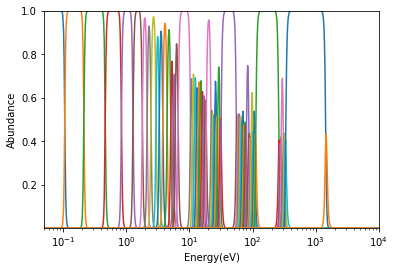

In [11]:
#Make a note that the structure of this YI is multidimensional, with a shape of (1,2198,N)
Ytot = np.sum(YI[0],1)
for i in range(len(ion_potential[0])):
    plt.semilogx(kbEvpGK*np.array(full_temp),(YI[0][:,i])/Ytot[0])

plt.ylim([1.e-5, 1])
plt.xlim([0.05, 1e4])
plt.xlabel("Energy(eV)")
plt.ylabel("Abundance")

In [21]:
YI[0]

NameError: name 'YI' is not defined